In [1]:
from zipfile import ZipFile
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
import csv

2022-12-13 02:37:40.030202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 02:37:40.141978: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andrewsue/.local/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/lib:/opt/ros/melodic/lib:/usr/lib:/usr/share:/home/andrewsue/open3d_install_v9/lib
2022-12-13 02:37:40.141998: I tensorflow/tsl/cuda/cudart_stub.cc:28] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 02:37:40.185388: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics wi

In [ ]:
'''def extract_zip(src, dest):
    '''
    #Extracts the contents downloaded from the URL
    '''
    zip_ref = ZipFile(src,'r')
    zip_ref.extractall(dest)
    zip_ref.close()

extract_zip('nyu_data.zip', '/content')'''

In [3]:
#Hyper params
split = 0.8
height, width = 240, 320 

In [4]:
random.seed(0)
with open("training_set.csv", "w") as f:
    writer = csv.writer(f)
    for i in range(1999):
        if random.random() > 0.2:
            end = str(i) + ".png"
            dep = "saved_img_env1_5/depth_" + end
            rgb = "saved_img_env1_5/rgb_" + end
            row = [rgb, dep]
            # write a row to the csv file
            writer.writerow(row)
            
random.seed(0)
with open("test_set.csv", "w") as f:
    writer = csv.writer(f)
    for i in range(1999):
        randnum = random.random()
        if randnum > 0.1 and randnum <= 0.2:
            end = str(i) + ".png"
            dep = "saved_img_env1_5/depth_" + end
            rgb = "saved_img_env1_5/rgb_" + end
            row = [rgb, dep]
            # write a row to the csv file
            writer.writerow(row)
            
random.seed(0)
with open("validation_set.csv", "w") as f:
    writer = csv.writer(f)
    for i in range(1999):
        randnum = random.random()
        if randnum <= 0.1:
            end = str(i) + ".png"
            dep = "saved_img_env1_5/depth_" + end
            rgb = "saved_img_env1_5/rgb_" + end
            row = [rgb, dep]
            # write a row to the csv file
            writer.writerow(row)

In [5]:
#train_df = pd.read_csv('content/data/nyu2_train.csv',header=None)
#test = pd.read_csv('content/data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})

# using my custom dataset instead of NYU2
train_df = pd.read_csv('training_set.csv',header=None)
test = pd.read_csv('test_set.csv',header=None).rename(columns={0:'image', 1:'depth'})

train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*split)


train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(1287, 322)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
        # for reproducibility
        np.random.seed(43)
        # dataframe containing the subset of image and depth pairs
        self.df = dataframe
        # chosen Height and Width of the RGB image
        self.height, self.width = dim
        # choice of shuffling the data
        self.shuffle = shuffle
        self.batch_size = batch_size
        # unique set of RGB images
        self.ids = dataframe['image'].unique()
        # Map the image with depth maps
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        '''
        Returns the length of dataset.
        '''
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        '''
        Shuffles the data at the end of every epoch
        '''
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
  
    def __getitem__(self,index):
        '''
        returns the batch of image and depth pairs 
        '''
        # select the batch of pair indexes 
        idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        # randomly select whether to flip the image
        flip = np.random.choice([True, False])
        # select the image id's for the above indexes
        query_imgs = [self.ids[idx] for idx in idxs]
        # select corresponding depth pair for the image
        target_imgs = [self.imgtodpth[img] for img in query_imgs]
        # preprocess the image 
        processed_query_img = self._preprocess_image(query_imgs, flip)
        # preprocess the depth map
        processed_depth_img = self._preprocess_depth(target_imgs, flip)
        return processed_query_img, processed_depth_img

    def _preprocess_image(self,images, flip):
        '''
        Resize, Normalize and randomly Augments the image set. 
        '''
        # placeholder for storing the processed images
        processed = []
        for img in images:
          # resize the image to 640x480
          resized_img = cv2.resize(cv2.imread(img),(self.height,self.width)).astype(np.float32)
          # normalize the image to {0,1}
          scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
          # flip the image horizontally
          if flip:
            scaled_img = cv2.flip(scaled_img, 1)
          # finally append each image
          processed.append(scaled_img)
        return np.array(processed)

    def _preprocess_depth(self,images, flip):
        '''
        Resize, Normalize and randomly Augments the depth maps.
        '''
        # placeholder for storing the processed depth maps
        processed = []
        for img in images:
            # resize the depth map to 320x240
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(320,240)).astype(np.float32)
            # normalize it to range {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            # finally append the image
            processed.append(scaled_img)
        return np.array(processed)


In [23]:
train_generator = DataGenerator(train, batch_size=8, shuffle=True, dim=(640,480))
val_generator = DataGenerator(validation, batch_size=8, shuffle=False, dim=(640,480))
test_generator = DataGenerator(test, batch_size=16, shuffle=False, dim=(640,480))
print(len(train_generator), len(val_generator), len(test_generator))

160 40 11


In [27]:
runID = str(1) #str(int(time.time())) + '-n' + str(len(train_generator)) + '-e' + str(args.epochs) + '-bs' + str(args.bs) + '-lr' + str(args.lr) + '-' + args.name
outputPath = './models/'
runPath = outputPath + runID
import pathlib
pathlib.Path(runPath).mkdir(parents=True, exist_ok=True)
print('Output: ' + runPath)


Output: ./models/1


In [8]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(8, 480, 640, 3) (8, 240, 320, 1)


/home/andrewsue/.local/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


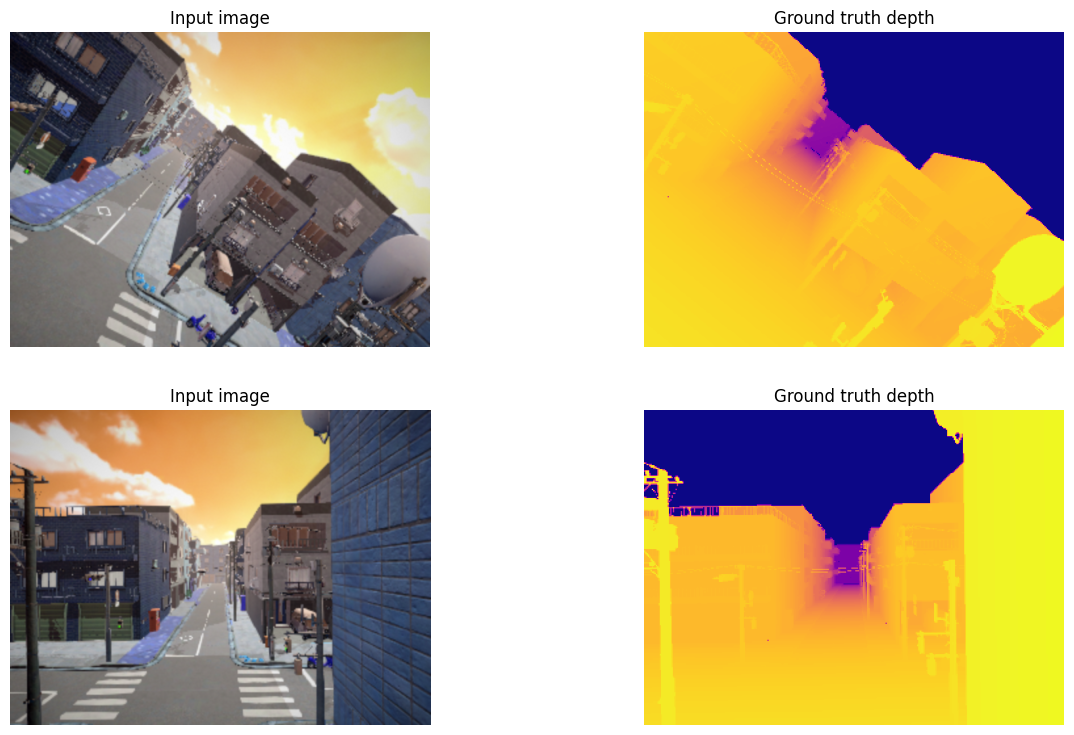

In [9]:
# visualize some example RGB + depth images from my Flightmare dataset
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
    image = images[i]
    depth = depths[i].squeeze(-1)
    plt.subplot(221+i)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Input image')
    plt.subplot(222+i)
    plt.axis('off')
    plt.imshow(depth,cmap=plt.get_cmap(cmap))
    plt.title('Ground truth depth')


In [30]:
# Model
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, concatenate, Concatenate, Input
from tensorflow.keras import Model

def upsampling(input_tensor, n_filters, concat_layer):
    '''
    Block of Decoder
    '''
    # Bilinear 2x upsampling layer
    x = UpSampling2D(size=(2,2), interpolation='bilinear')(input_tensor)
    # concatenation with encoder block 
    x = concatenate([x,concat_layer])
    # decreasing the depth filters by half
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    return x

# Layer name of encoders to be concatenated
names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
# Transfer learning approach without the classification head
encoder = DenseNet169(include_top=False, weights='imagenet', input_shape=(480,640,3))
for layer in encoder.layers:
    layer.trainable = True
inputs = encoder.input
x = encoder.output
# decoder blocks linked with corresponding encoder blocks
bneck = Conv2D(filters=1664, kernel_size=(1,1), padding='same')(x)
x = LeakyReLU(alpha=0.2)(bneck)
x = upsampling(bneck, 832, encoder.get_layer(names[0]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 416, encoder.get_layer(names[1]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 208, encoder.get_layer(names[2]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 104, encoder.get_layer(names[3]).output)
x = Conv2D(filters=1, activation='sigmoid', kernel_size=(3,3), padding='same')(x)

model = Model(inputs=inputs, outputs=x)
#model.summary()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

def loss_function(y_true, y_pred):
    #Cosine distance loss
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # edge loss for sharp edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # structural similarity loss
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    # weightage
    w1, w2, w3 = 1.0, 1.0, 0.1
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))



#optimizer
#opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)
#opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001, amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/project/densenet_final',
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 10
    base_lr =  0.0001
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]


In [ ]:
for layer in encoder.layers:
    layer.trainable = True
    print(layer.trainable)

In [28]:
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
history = model.fit(train_generator, validation_data=val_generator, epochs=10,callbacks=callbacks)

In [ ]:
## The above step results in a loss of NaN and accuracy of 0

In [ ]:
model.evaluate(test_generator)

In [ ]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

In [ ]:
cmap = "plasma_r"


for i in range(len(images)):
    plt.figure(figsize=(19,10))
    pred = preds[i]
    pred = np.squeeze(pred, axis=-1)
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.imshow(pred, cmap=plt.get_cmap(cmap))

    plt.subplot(1,3,2)
    plt.axis("off")
    img = labels[i]
    img = np.squeeze(img, axis=-1)
    plt.imshow(img, cmap=plt.get_cmap(cmap))

    plt.subplot(1,3,3)
    plt.axis("off")
    img1 = images[i]
    plt.imshow(img1)

    plt.show()